## Step 1. 데이터셋 내려받기

In [9]:
import tensorflow_datasets as tfds
import tensorflow as tf

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [10]:
F_IMG = 160 # 해상도 160 X 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (F_IMG, F_IMG))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## Step 3. 모델 설계하기

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

## Step 4. 모델 학습시키기

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 8s 52ms/step - loss: 0.7194 - accuracy: 0.7377 - val_loss: 0.4635 - val_accuracy: 0.8447
Epoch 2/10
92/92 [==============================] - 4s 33ms/step - loss: 0.3425 - accuracy: 0.8920 - val_loss: 0.3711 - val_accuracy: 0.8719
Epoch 3/10
92/92 [==============================] - 3s 33ms/step - loss: 0.2627 - accuracy: 0.9196 - val_loss: 0.3387 - val_accuracy: 0.8747
Epoch 4/10
92/92 [==============================] - 4s 34ms/step - loss: 0.2142 - accuracy: 0.9343 - val_loss: 0.3206 - val_accuracy: 0.8801
Epoch 5/10
92/92 [==============================] - 3s 33ms/step - loss: 0.1810 - accuracy: 0.9475 - val_loss: 0.3186 - val_accuracy: 0.8801
Epoch 6/10
92/92 [==============================] - 4s 33ms/step - loss: 0.1577 - accuracy: 0.9581 - val_loss: 0.3237 - val_accuracy: 0.8801
Epoch 7/10
92/92 [==============================] - 4s 34ms/step - loss: 0.1363 - accuracy: 0.9629 - val_loss: 0.3065 - val_accuracy: 0.8856
Epoch 8/10
92

## Step 5. 모델 성능 평가하기


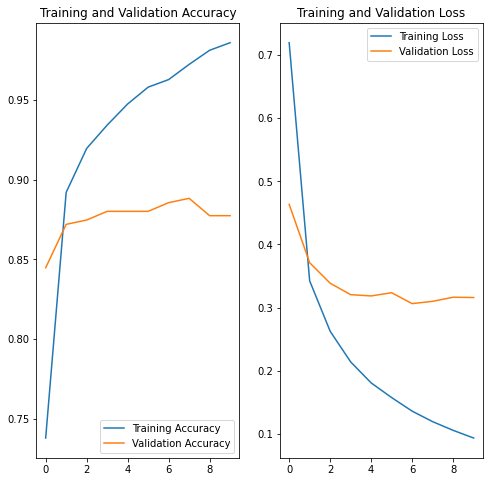

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Step 6. 모델 활용하기

In [14]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.29372129e-04, 7.96701945e-03, 6.46591485e-01, 1.82886515e-03,
        3.43483239e-01],
       [9.99997020e-01, 1.58648481e-06, 1.49092401e-07, 1.38853542e-08,
        1.27730277e-06],
       [4.48089540e-01, 3.96020216e-04, 2.02922020e-04, 5.51300287e-01,
        1.11704421e-05],
       [2.29192642e-03, 9.95644834e-03, 9.46863890e-01, 1.45253232e-02,
        2.63624396e-02],
       [9.96490180e-01, 5.12069906e-04, 1.76459525e-05, 1.85022891e-05,
        2.96156481e-03],
       [9.99954224e-01, 3.46911220e-05, 1.20931730e-07, 1.01365395e-05,
        7.82147083e-07],
       [4.91833827e-03, 1.93410995e-03, 9.82918859e-01, 9.73750278e-03,
        4.91203973e-04],
       [2.49008508e-03, 5.97908914e-01, 3.53585383e-05, 3.99545461e-01,
        2.01962393e-05],
       [4.91609215e-04, 2.25639553e-07, 3.92657734e-04, 9.98998225e-01,
        1.17314696e-04],
       [9.99992728e-01, 2.22968015e-06, 1.27917772e-07, 4.15349568e-08,
        4.83665144e-06],
       [9.92129982e-01, 7.7370

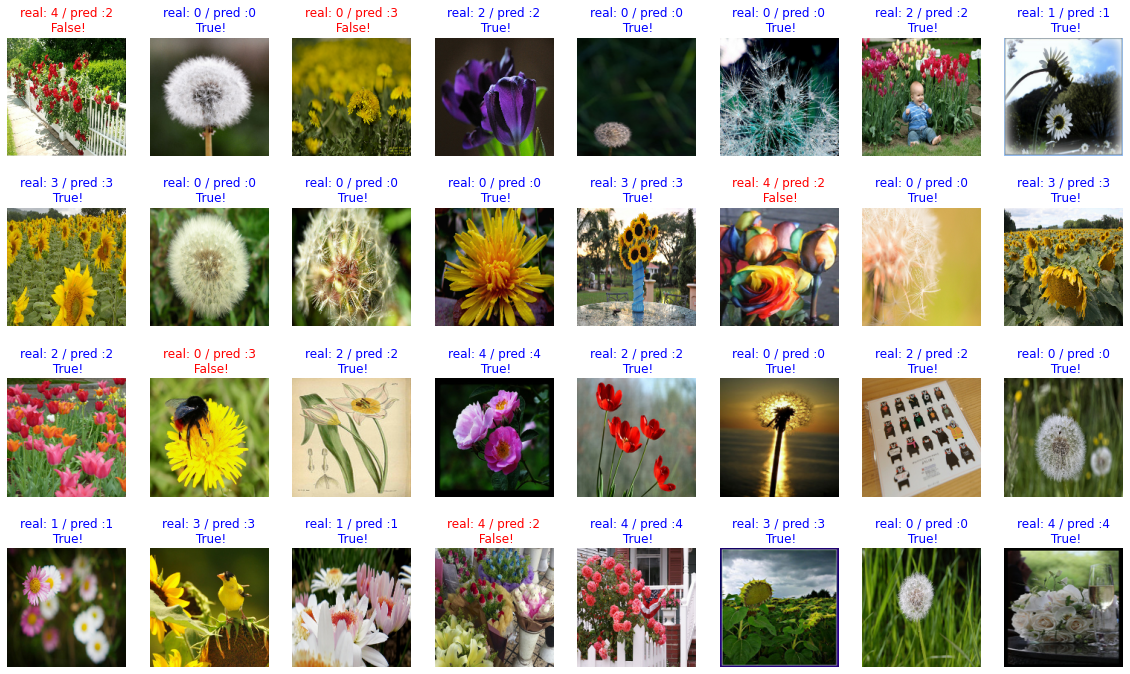

In [15]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [16]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

84.375
